In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/MyDrive/5153_GP'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/5153_GP
/content/gdrive/MyDrive/5153_GP


In [3]:
df_grouped = pd.read_csv('group_filted_data_01.csv')
print(df_grouped.shape)

(39565, 7)


In [4]:
df_grouped.drop('comment_id', axis=1, inplace=True)
df_grouped

,speeches,status,violence,genocide,dehumanize,humiliate
0,White people are trash.,1,0,0,1,1
1,"You've caught the big gay, it's known to be ai...",1,0,0,1,1
2,"I'm not saying you said that, I'm just saying ...",1,0,0,1,1
3,Donald Trump. Yeet myself off a building onto ...,1,0,0,1,1
4,Fabrice Fabrice is ostensibly black or black/l...,1,0,0,1,1
...,...,...,...,...,...,...
39560,Good you Americans are annoying asf. I Wish mo...,1,1,1,1,1
39561,Go to streets of the USA and our kids and vets...,1,1,1,1,1
39562,That Kenyan girl is gorgeous!,1,0,0,0,0
39563,Yikes!!! Bad enough she'shard to look at.every...,1,1,0,1,1


In [5]:
from sklearn.model_selection import train_test_split

# train, validation, test: 40-30-30
df_train, df_test = train_test_split(df_grouped, test_size=0.6, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)
df_train.shape, df_val.shape, df_test.shape

((15826, 6), (11869, 6), (11870, 6))

In [7]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)

# Fit TF-IDF on training data and transform all datasets
X_train_tfidf = tfidf.fit_transform(df_train['speeches']).toarray()
X_val_tfidf = tfidf.transform(df_val['speeches']).toarray()
X_test_tfidf = tfidf.transform(df_test['speeches']).toarray()


In [8]:
C_values = [0.1, 0.5, 1, 5, 10]
target_columns = ['status', 'violence', 'genocide', 'dehumanize', 'humiliate']
# Initialize a dictionary to store results for visualization
validation_scores = {column: [] for column in target_columns}

# find the best model
best_models = {}
for column in target_columns:
    best_score = 0
    best_model = None
    scores_for_this_column = []

    for C in C_values:
        model = SVC(kernel='linear', C=C)
        model.fit(X_train_tfidf, df_train[column])
        y_val_pred = model.predict(X_val_tfidf)
        score = accuracy_score(df_val[column], y_val_pred)
        scores_for_this_column.append(score)

        if score > best_score:
            best_score = score
            best_model = model

    best_models[column] = best_model
    validation_scores[column] = scores_for_this_column
    print(f"Best validation score for {column}: {best_score}")




Best validation score for status: 0.9916589434661723
Best validation score for violence: 0.696604600219058
Best validation score for genocide: 0.8277024180638638
Best validation score for dehumanize: 0.7581936136153004
Best validation score for humiliate: 0.8445530373241217


In [11]:
for column in target_columns:
    best_model = best_models[column]
    best_c = best_model.C
    print(f"Best C value for {column}: {best_c}")


Best C value for status: 0.1
Best C value for violence: 1
Best C value for genocide: 1
Best C value for dehumanize: 1
Best C value for humiliate: 5


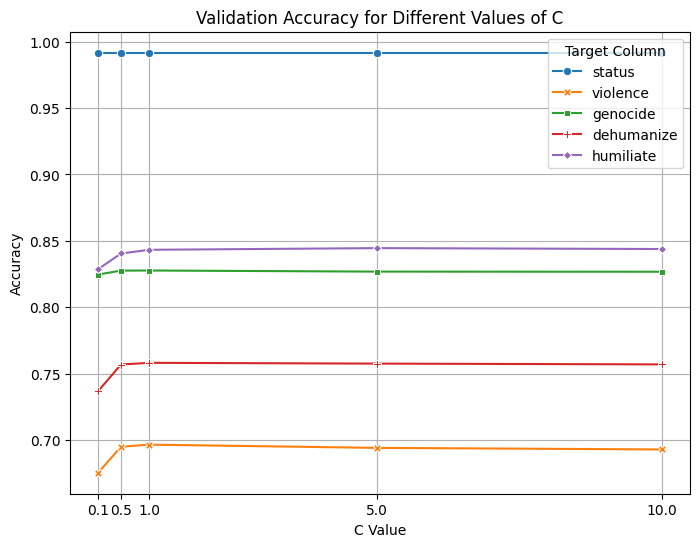

In [9]:
# Convert the dictionary to a DataFrame for easier plotting
df_scores = pd.DataFrame(validation_scores, index=C_values)

# Plotting
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_scores, markers=True, dashes=False)
plt.title('Validation Accuracy for Different Values of C')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.xticks(C_values)
plt.legend(title='Target Column')
plt.grid(True)
plt.show()

In [10]:
test_scores = {}
for column in target_columns:
    y_test_pred = best_models[column].predict(X_test_tfidf)
    test_score = accuracy_score(df_test[column], y_test_pred)
    test_scores[column] = test_score
    print(f"Test accuracy for {column}: {test_score}")

Test accuracy for status: 0.9896377422072452
Test accuracy for violence: 0.682055602358888
Test accuracy for genocide: 0.8245998315080034
Test accuracy for dehumanize: 0.758972198820556
Test accuracy for humiliate: 0.8482729570345409


In [12]:
svm_scores = pd.DataFrame(list(test_scores.items()), columns=['Category', 'Accuracy Score'])
svm_scores.to_csv('svm_test_scores.csv', index=False)
